# Necesidad de VAE

Los codificadores automáticos `(Auto Enconders)` son adecuados para codificar y decodificar, pero no funcionan bien cuando los usamos para generar contenido. Para generar contenido, tomamos un atributo latente y usamos un decodificador para generar contenido. Aquí, se utiliza una única característica latente, ya que representa una dimensión de codificación, y el decodificador luego la usará para recrear una entrada real.

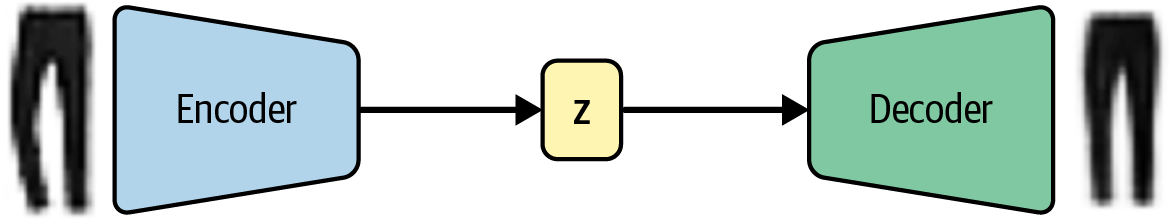

# Codificadores automáticos variacionales (VAE)

En VAE, la red generativa genera una distribución de probabilidad. Esta red generativa genera los parámetros de media y varianza para cada atributo latente que se utilizan para obtener la distribución de probabilidad requerida. El decodificador ahora toma muestras de esta distribución y reconstruye la entrada original a partir de estas muestras.

En un codificador automático `(AE)`, cada imagen se asigna directamente a un punto del espacio latente. En un codificador automático variacional `(VAE)`, cada imagen se asigna a una distribución normal multivariada alrededor de un punto en el espacio latente, como se muestra en la siguiente figura:

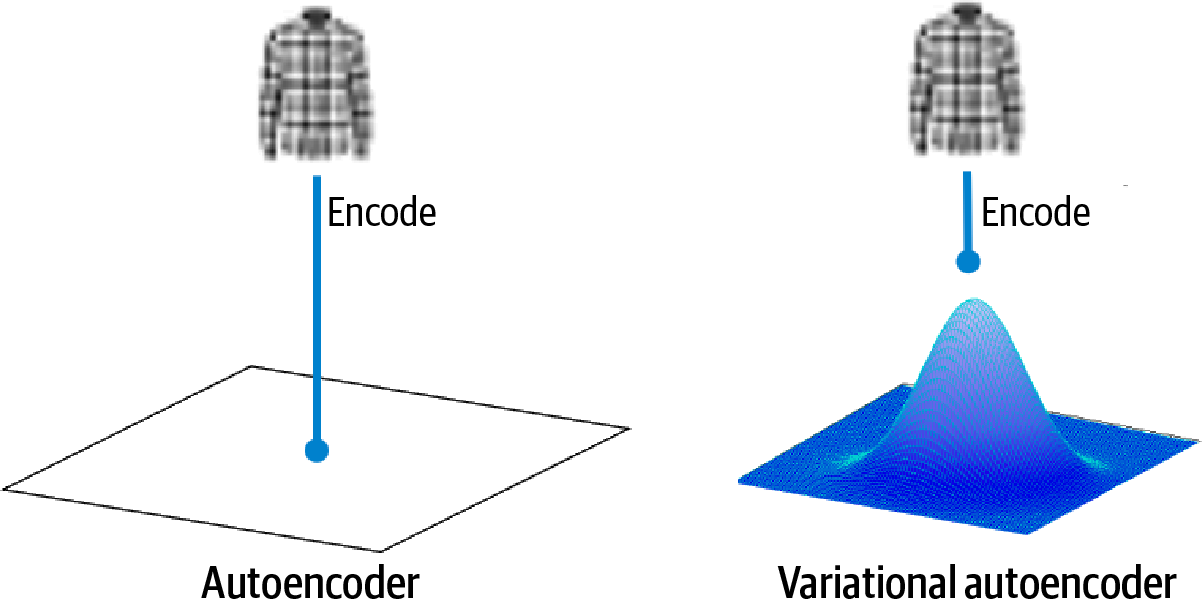


El decodificador de un codificador automático variacional es idéntico al decodificador de un codificador automático simple, lo que proporciona la arquitectura general que se muestra en la siguiente imagen:

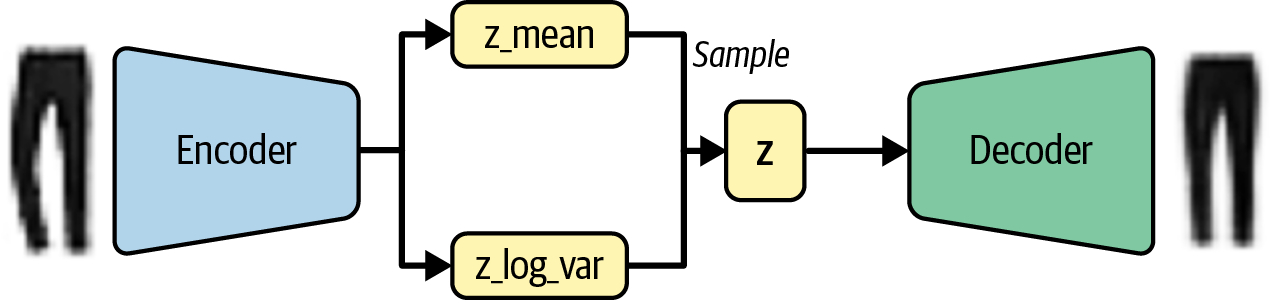

### Mi primer AutoEncoder Variacional con Keras

En este notebook vamos a ver cómo podemos implementar un autoencoder variacional paso a paso. Todos los ejemplos están extraídos del propio blog de Keras, aquí tienes el [enlace](https://blog.keras.io/building-autoencoders-in-keras.html) para su consulta. También he extraído imágenes e información de [este](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) y [este](http://www.cs.us.es/~fsancho/?e=232) enlace que os dejo para tu consulta. Y [este](https://www.jeremyjordan.me/variational-autoencoders/) por si deseas ampliar con algo "más matemático".

Comenzemos recordando qué es un autoencoder variacional. Para ello, repasemos la imagen siguiente:

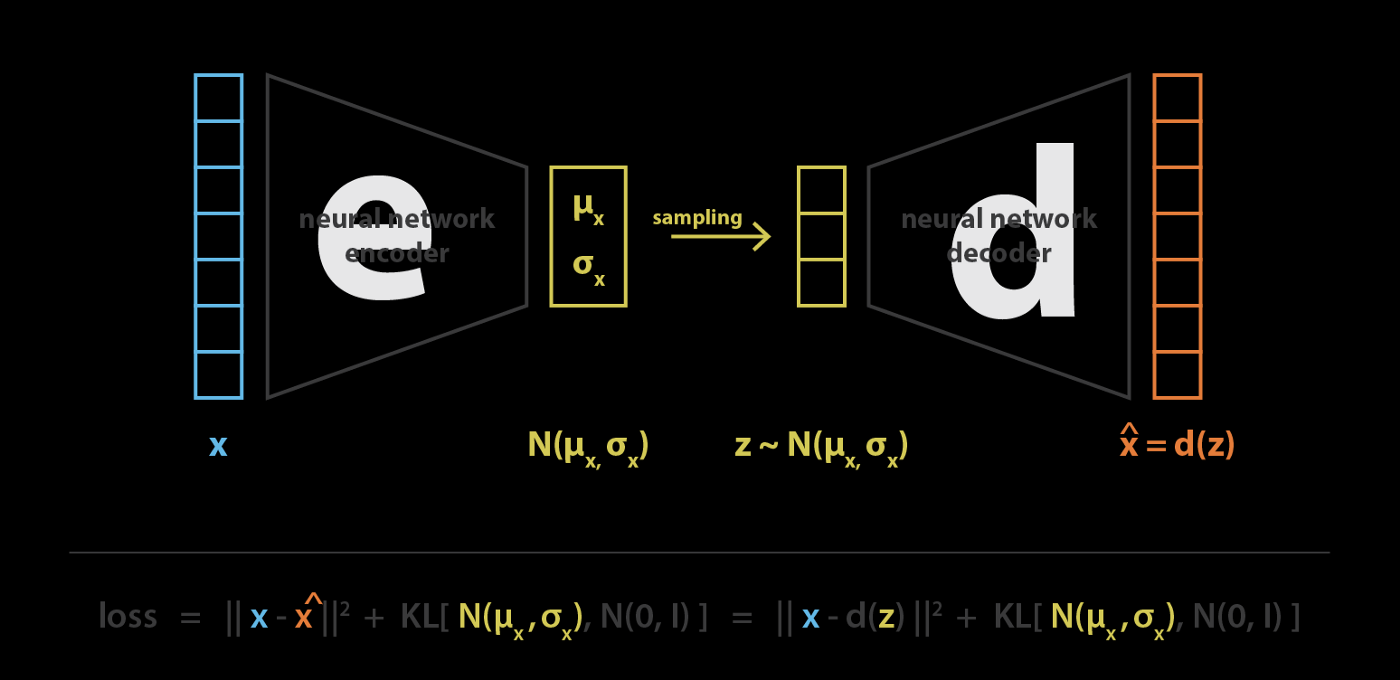

En ella podemos observar como, al igual que el autoencoder básico, consta de dos bloques: el encoder y el decoder. 

Por una parte, el **encoder** toma los datos de entrada y los comprime en una representación mucho más compacta. 

Por la otra, el **decoder** toma esa representación (o codificación) comprimida y trata de reconstruir los datos originales con el menor error posible.

La única diferencia es que el encoder, en este caso, no produce un "punto" en el espacio reducido, sino que produce una distribución de probabilidad. Es mediante el muestreo de esta distribución de probabilidad como somos capaces de regenerar los datos de entrada al introducirle la muestra obtenida al decoder.

## Cómo trabaja el AE vs VAE?

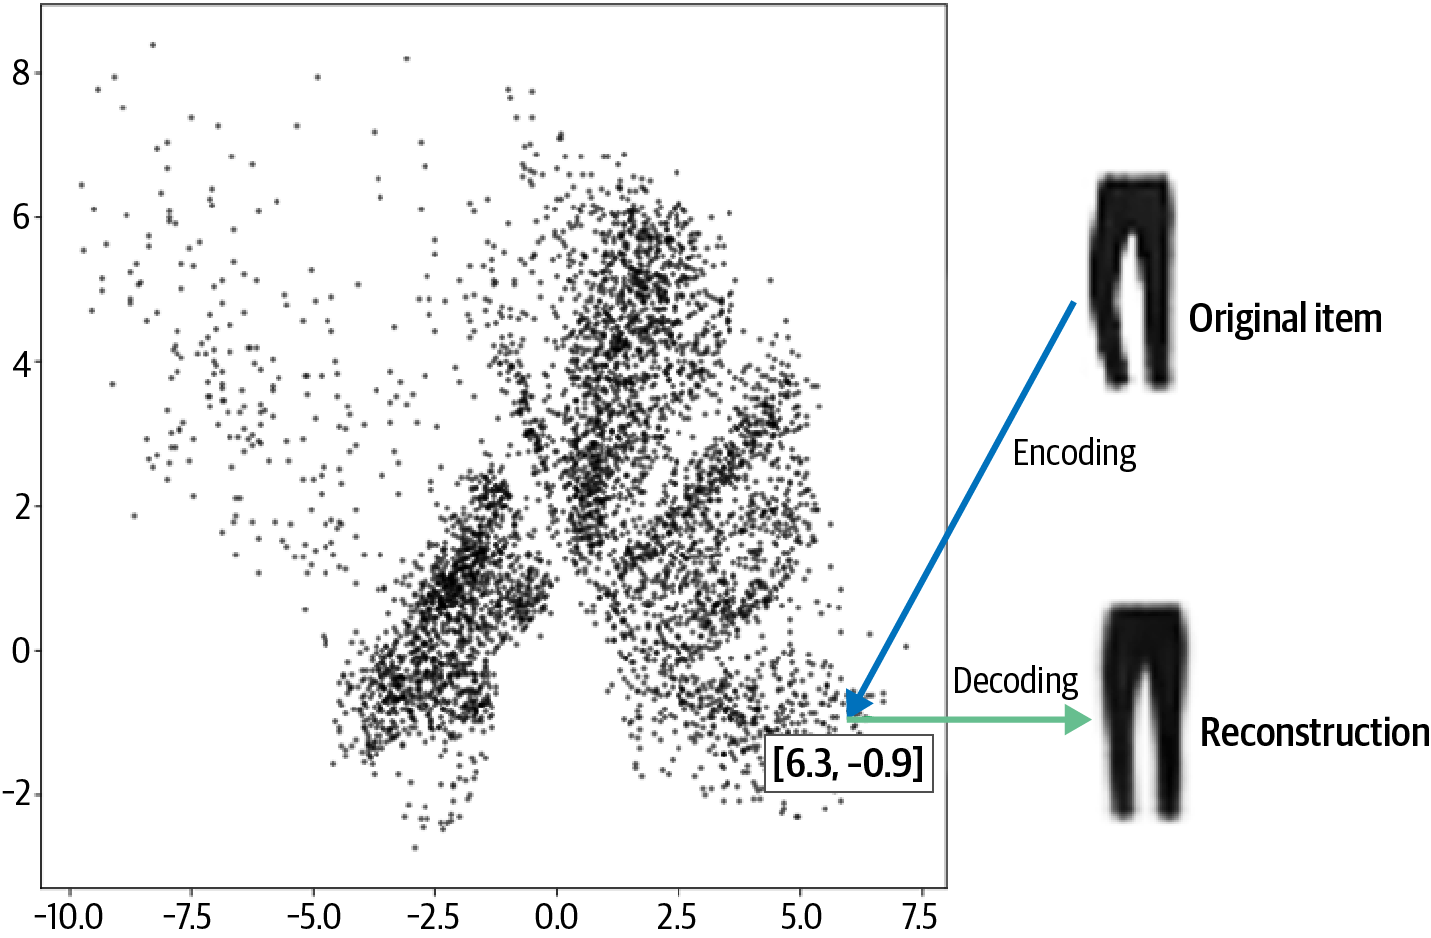

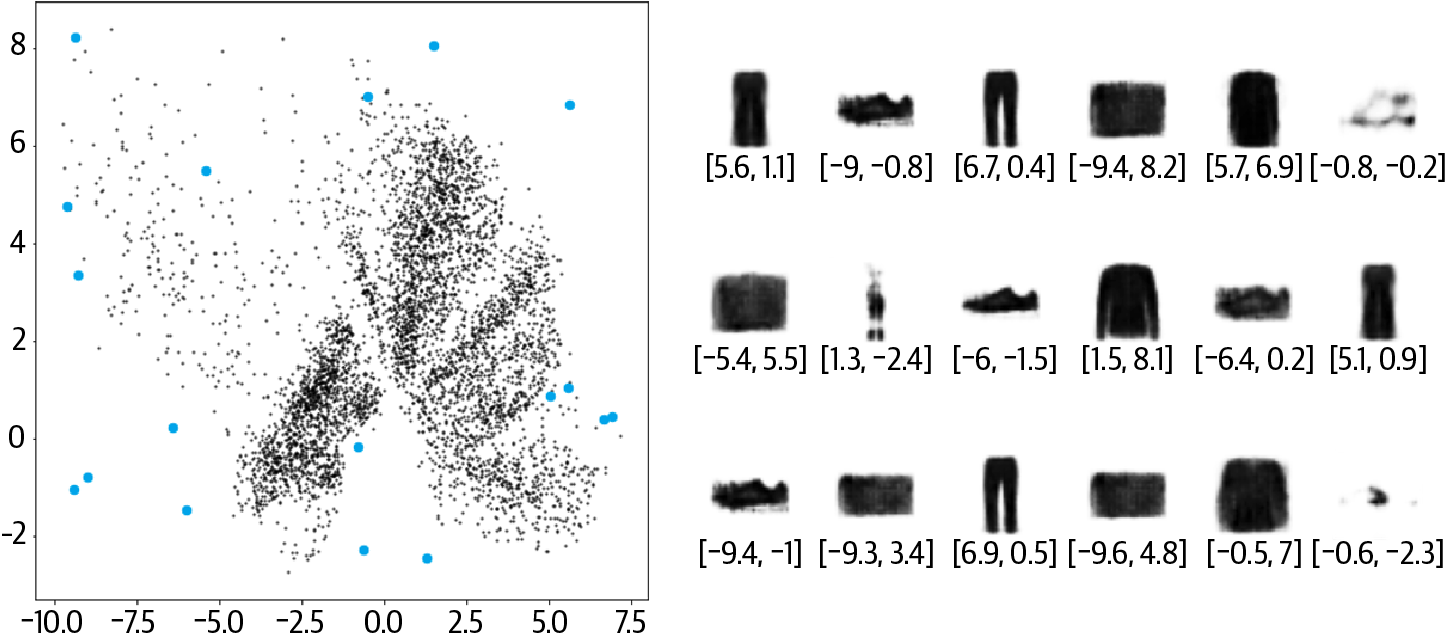


A lo largo de esta práctica haremos lo siguiente:

* Empezaremos con un AutoEncoder Variacional muy simple, en el que tanto el encoder como el decoder tendrán una sola capa Densa.


**¡Comenzemos!**

Vamos a construir el AutoEncoder Variacional más simple posible:

In [12]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

De la última capa creo otras dos capas, una que tenga la media y otra la varianza

In [13]:
import keras
from keras import layers

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)

z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)


Con la función `sampling` genero la capa de sampling ya que no existe una función de tensor
flow que pueda obtener eso.
La capa de sampling solo trabaja solo las capas de `z_mean` o `z_log_sigma`.


Al agregar `Lambda`, me crea una nueva capa con la función que le este pasando.

In [14]:
from keras import backend as K


def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon #Sampling, Media + desviación * epsilon


z = layers.Lambda(sampling)([z_mean, z_log_sigma]) #Espacio latente

In [15]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

In [ ]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [16]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss) # Añadimos las perdidas
vae.compile(optimizer='adam')

In [17]:
import numpy as np
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/100


2023-10-16 21:08:26.699047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1870/1875 [============================>.] - ETA: 0s - loss: 186.0919

2023-10-16 21:08:37.699991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 12s 6ms/step - loss: 186.0361 - val_loss: 166.8861
Epoch 2/100
1875/1875 [==============================] - 11s 6ms/step - loss: 164.7507 - val_loss: 162.9387
Epoch 3/100
1875/1875 [==============================] - 10s 6ms/step - loss: 161.8193 - val_loss: 160.8990
Epoch 4/100
1875/1875 [==============================] - 11s 6ms/step - loss: 159.9350 - val_loss: 159.4243
Epoch 5/100
1875/1875 [==============================] - 11s 6ms/step - loss: 158.4940 - val_loss: 157.9277
Epoch 6/100
1875/1875 [==============================] - 11s 6ms/step - loss: 157.4000 - val_loss: 157.3322
Epoch 7/100
1875/1875 [==============================] - 11s 6ms/step - loss: 156.5093 - val_loss: 156.3300
Epoch 8/100
1875/1875 [==============================] - 11s 6ms/step - loss: 155.6828 - val_loss: 155.4656
Epoch 9/100
1875/1875 [==============================] - 11s 6ms/step - loss: 154.8976 - val_loss: 154.9714
Epoch 10/100
1875/1875 [================

In [18]:
import matplotlib.pyplot as plt

x_test_encoded = encoder.predict(x_test, batch_size=32)

2023-10-16 21:29:18.351356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 10s 29ms/step


In [19]:
x_test_encoded = np.asarray(x_test_encoded)

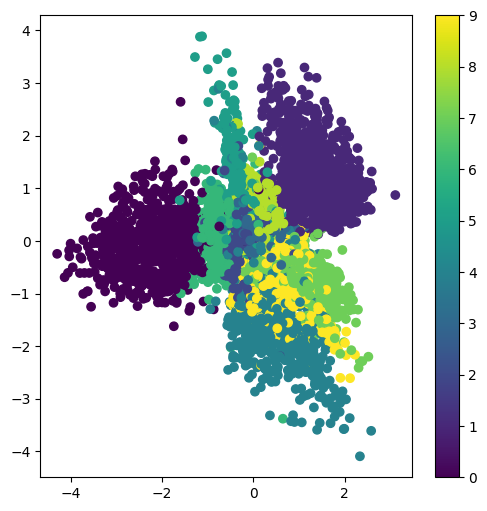

In [20]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[2, :, 0], x_test_encoded[2, :, 1], c=y_test)
plt.colorbar()
plt.show()

2023-10-16 21:30:01.664091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 65ms/step


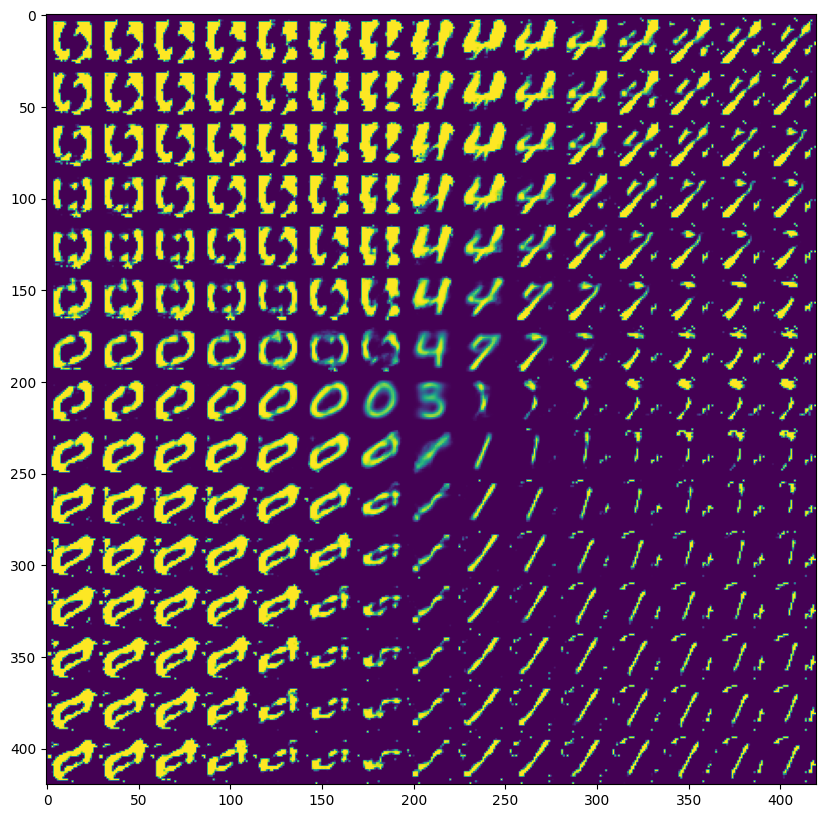

In [21]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

Y con esto, tenemos nuestro primer VAE implementado.